## Load data

In [1]:
#@markdown ---------------
#@markdown ## **⚠️❗ Ejecute esta celda para descargar Shoes dataset❗⚠️**
#@markdown ### Esta celda creará la carpeta ```/content/shoes_data```

!pip install -qq gdown
!gdown -qq "https://drive.google.com/uc?id=1_fIMm5nPp0BLJZKfkJZ_juRmLpRK4iA0" -O /shoes_data.zip
!mkdir /content/shoes_data/
!unzip -qq /shoes_data.zip -d /content/shoes_data
!rm -r /shoes_data.zip
print ("Done!")
#@markdown ---------------

Done!


In [2]:
!apt install neofetch

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  caca-utils chafa fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick imagemagick-6-common imagemagick-6.q16 jp2a libchafa0 libdjvulibre-text
  libdjvulibre21 libfftw3-double3 libgs9 libgs9-common libid3tag0 libidn12 libijs-0.35 libimlib2
  libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra
  libmagickwand-6.q16-6 libnetpbm10 libpci3 libsixel-bin libsixel1 libwmflite-0.2-7 netpbm pci.ids
  pciutils poppler-data toilet toilet-fonts w3m w3m-img
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x imagemagick-doc
  autotrace cups-bsd | lpr | lprng enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer
  povray radiance sane-utils texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev
  inkscape poppl

In [3]:
!neofetch
!nvidia-smi

            .-/+oossssoo+/-.
        `:+ssssssssssssssssss+:`
      -+ssssssssssssssssssyyssss+-
    .ossssssssssssssssssdMMMNysssso.
   /ssssssssssshdmmNNmmyNMMMMhssssss/
  +ssssssssshmydMMMMMMMNddddyssssssss+
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/
.ssssssssdMMMNhsssssssssshNMMMdssssssss.
+sssshhhyNMMNyssssssssssssyNMMMysssssss+
ossyNMMMNyMMhsssssssssssssshmmmhssssssso
ossyNMMMNyMMhsssssssssssssshmmmhssssssso
+sssshhhyNMMNyssssssssssssyNMMMysssssss+
.ssssssssdMMMNhsssssssssshNMMMdssssssss.
 /sssssssshNMMMyhhyyyyhdNMMMNhssssssss/
  +sssssssssdmydMMMMMMMMddddyssssssss+
   /ssssssssssshdmNNNNmyNMMMMhssssss/
    .ossssssssssssssssssdMMMNysssso.
      -+sssssssssssssssssyyyssss+-
        `:+ssssssssssssssssss+:`
            .-/+oossssoo+/-.
root@da5a5879b1a1 
----------------- 
OS: Ubuntu 22.04.2 LTS x86_64 
Host: Google Compute Engine 
Kernel: 5.15.120+ 
Uptime: 7 mins 
Packages: 1296 (dpkg) 
Shell: bash 5.1.16 
Terminal: jupyter-noteboo 
CPU: Intel Xeon (2) @ 2.299GHz 
GPU: NVIDIA Tesla

In [4]:
!ls /content/shoes_data/train/Boot/ | wc -l

4000


## Some imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

## Prepare data

In [6]:
batch_size = 200
learning_rate = 1e-3
epochs = 20

In [7]:
image_transforms = T.Compose([\
                              T.Resize((64,64)),
                              T.RandomPerspective(distortion_scale=0.6, p=1),
                              T.ToTensor()])

In [8]:
train_data = datasets.ImageFolder(root='/content/shoes_data/train', transform=image_transforms)
test_data  = datasets.ImageFolder(root='/content/shoes_data/test', transform=image_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data , batch_size=batch_size)

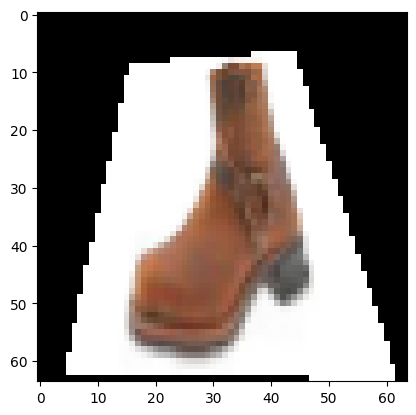

In [9]:
plt.imshow(train_data[0][0].numpy().transpose(1,2,0))

## Create Model

In [10]:
model = nn.Sequential (
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=30, out_channels=40, kernel_size=3, padding=1), nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=40*8*8, out_features=256), nn.ReLU(),
    nn.Linear(in_features=256, out_features=128), nn.ReLU(),
    nn.Linear(in_features=128, out_features=3), nn.Softmax()
)

summary(model.cuda(), input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 64, 64]             280
              ReLU-2           [-1, 10, 64, 64]               0
         MaxPool2d-3           [-1, 10, 32, 32]               0
            Conv2d-4           [-1, 20, 32, 32]           1,820
              ReLU-5           [-1, 20, 32, 32]               0
         MaxPool2d-6           [-1, 20, 16, 16]               0
            Conv2d-7           [-1, 30, 16, 16]           5,430
              ReLU-8           [-1, 30, 16, 16]               0
         MaxPool2d-9             [-1, 30, 8, 8]               0
           Conv2d-10             [-1, 40, 8, 8]          10,840
             ReLU-11             [-1, 40, 8, 8]               0
          Flatten-12                 [-1, 2560]               0
           Linear-13                  [-1, 256]         655,616
             ReLU-14                  [

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


## Create loss and optimizer

In [11]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.cuda()
loss.cuda()

CrossEntropyLoss()

## Start Training

In [12]:
losses = []
progress = tqdm(range(epochs), ncols=110)

for epoch in progress:
  #
  batch_losses = 0
  for batch_i, (batch_X, batch_y) in enumerate(train_loader):
    #
    batch_X = batch_X.cuda()
    batch_y = batch_y.cuda()

    ###----- Training cycle -----###
    optimizer.zero_grad()

    predictions = model(batch_X)

    batch_loss = loss(predictions, batch_y)

    batch_loss.backward()

    optimizer.step()
    #################################

    batch_losses += batch_loss.item()

  epoch_loss = batch_losses / len(train_loader)
  losses.append(epoch_loss)

  progress.set_description("[Epoch: {0}/{1}] [Loss: {2:0.5f}]".format(epoch, epochs, epoch_loss))


[Epoch: 19/20] [Loss: 0.62504]: 100%|█████████████████████████████████████████| 20/20 [06:54<00:00, 20.73s/it]


<Axes: >

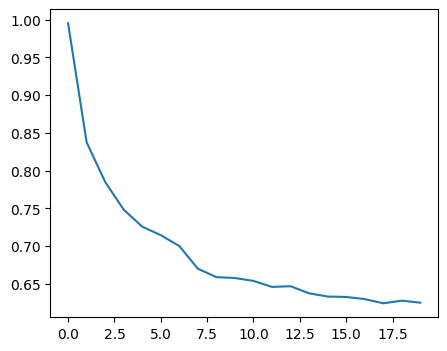

In [19]:
import seaborn as sns

_, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x=np.arange(len(losses)), y=losses)

## Validation

In [15]:
predictions = []
targets = []
progress = tqdm(enumerate(test_loader), ncols=100, total=len(test_loader))

for batch_i, (batch_X, batch_y) in progress:
  #
  batch_X = batch_X.cuda()

  batch_pred = model(batch_X)

  predictions.extend(np.argmax(batch_pred.detach().cpu().numpy(), axis=1))
  targets.extend(batch_y.detach().numpy())

predictions = np.array(predictions)
targets = np.array(targets)

print (predictions.shape, targets.shape)

  0%|                                                                        | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.01it/s]

(3000,) (3000,)


Acc: 0.917


<Axes: >

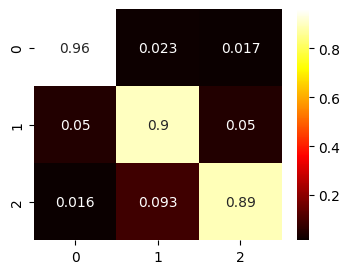

In [17]:
import seaborn as sns

acc = accuracy_score(targets, predictions)
cm_ = confusion_matrix(targets, predictions)
cmn = cm_ / cm_.sum(axis=1)

print("Acc: {0}".format(acc))
_, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cmn, annot=True, cmap="hot", ax=ax)

In [21]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
model_2 = nn.Sequential (
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=30, out_channels=40, kernel_size=3, padding=1), nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=40*8*8, out_features=256), nn.ReLU(),
    nn.Linear(in_features=256, out_features=128), nn.ReLU(),
    nn.Linear(in_features=128, out_features=3), nn.Softmax()
)

model_2.load_state_dict(torch.load("model.pth"))
summary(model_2.cuda(), input_size=(3,64,64))

In [ ]:
predictions = []
targets = []
progress = tqdm(enumerate(test_loader), ncols=100, total=len(test_loader))

for batch_i, (batch_X, batch_y) in progress:
  #
  batch_X = batch_X.cuda()

  batch_pred = model_2(batch_X)

  predictions.extend(np.argmax(batch_pred.detach().cpu().numpy(), axis=1))
  targets.extend(batch_y.detach().numpy())

predictions = np.array(predictions)
targets = np.array(targets)

print (predictions.shape, targets.shape)

Acc: 0.923


<Axes: >

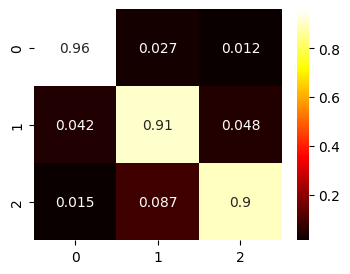

In [27]:
import seaborn as sns

acc = accuracy_score(targets, predictions)
cm_ = confusion_matrix(targets, predictions)
cmn = cm_ / cm_.sum(axis=1)

print("Acc: {0}".format(acc))
_, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cmn, annot=True, cmap="hot", ax=ax)

In [28]:
!du -hs /content/model.pth

2.8M	/content/model.pth
